In [69]:
# данные с ультразвуком
# анализ звуковых сигналов, чтобы отличить камни и подводные бомбы друг от друга
# сонарные данные

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [71]:
# сила сигнала для различных частот и указано, является ли объект камнем или миной
df = pd.read_csv('sonar.all-data.csv')
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


<Axes: >

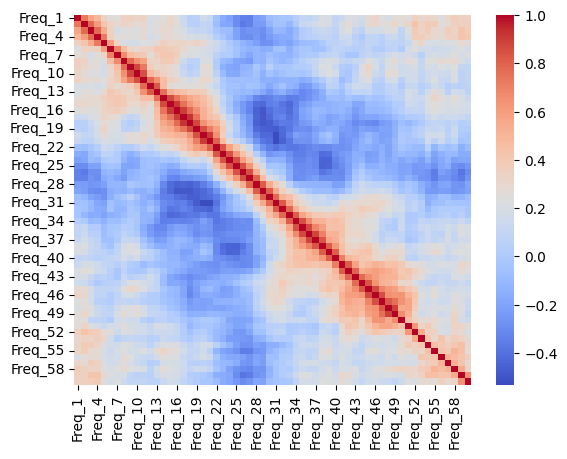

In [72]:
# тепловая карта, показывающая корреляцию между откликами различных частот
sns.heatmap(data=df.drop('Label',axis=1).corr(), cmap='coolwarm')

In [73]:
# какие 5 значение коррелируют лучше всего c целевой переменной?

In [74]:
df['Target'] = df['Label'].map({'R':0,'M':1}) # преобразуем целевую переменную . Камень - 0, мина - 1

In [75]:
np.abs(df.drop('Label', axis=1).corr()['Target']).sort_values().tail(6)

Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Target     1.000000
Name: Target, dtype: float64

In [76]:
# Разбиение на обучающих и тестовый наборы данных

In [77]:
X = df.drop(['Target','Label'], axis=1)

In [78]:
y = df['Label']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [80]:
# Создание PipeLine, в котором будет StandardScaler и модель KNN

In [81]:
knn_model = KNeighborsClassifier()
scaler = StandardScaler()

In [82]:
pipe = Pipeline((('scaler', scaler),('knn',knn_model)))

In [83]:
# C помощью паплайна будет выполняться поиск по сетке для различных значений k, чтобы найти оптимальные значения параметров

In [84]:
k_values = list(range(1,30))

In [85]:
param_grid = {'knn__n_neighbors': k_values}

In [86]:
grid_model = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy')

In [87]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=(('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier()))),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [88]:
grid_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Text(0, 0.5, 'Accuracy')

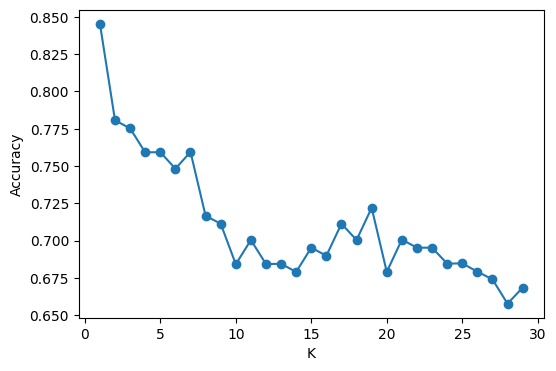

In [89]:
# График тестовых средних оценок для каждого k
fig, ax = plt.subplots(figsize=(6,4))
scores = grid_model.cv_results_['mean_test_score']
plt.plot(k_values,scores,'o-')
plt.xlabel("K")
plt.ylabel("Accuracy")

In [90]:
y_pred = grid_model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[12,  1],
       [ 1,  7]])

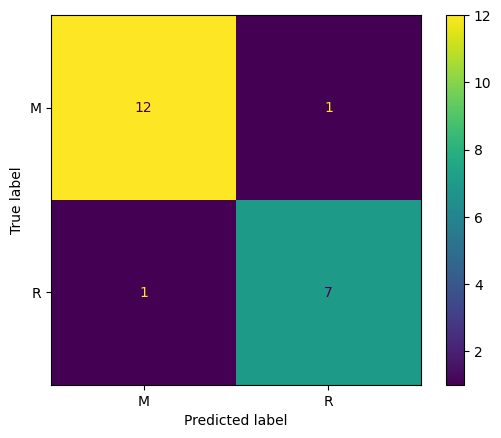

In [91]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test);

In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

